In [22]:
import os
import pandas as pd
import rasterio
import pylab as plt
from skimage import io
import numpy as np
from tqdm import tqdm

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle


In [2]:
df = pd.read_csv('data/features_metadata.csv')
"N test samples:", len(df[df['split'] == 'test']['chip_id'].unique())

('N test samples:', 2773)

In [3]:
df = df[df['split'] == 'train'].reset_index(drop=True)
len(df)

189078

In [4]:
df.head(3)

,filename,chip_id,satellite,split,month,size,cksum,s3path_us,s3path_eu,s3path_as,corresponding_agbm
0,0003d2eb_S1_00.tif,0003d2eb,S1,train,September,1049524,3953454613,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
1,0003d2eb_S1_01.tif,0003d2eb,S1,train,October,1049524,3531005382,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif
2,0003d2eb_S1_02.tif,0003d2eb,S1,train,November,1049524,1401197002,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,s3://drivendata-competition-biomassters-public...,0003d2eb_agbm.tif


In [5]:
unique_ids = df['chip_id'].unique()
len(unique_ids)

8689

In [6]:
img_path = 'image_data/train_features/'
labels_path = 'image_data/train_agbm/'

In [55]:
%%time
labels = []
imgs = []
for cur_id in tqdm(unique_ids[:100]):
    fn = img_path + rf"{cur_id}_S1_10.tif"
    if os.path.exists(fn):
        with rasterio.open(fn) as src:
            s1 = src.read()
    else:
        break
    fn = img_path + rf"{cur_id}_S2_10.tif"
    if os.path.exists(fn):
        with rasterio.open(fn) as src:
            s2 = src.read()
    else:
        break
        
    imgs.append(np.concatenate([s1, s2]))
    
    with rasterio.open(labels_path + rf"{cur_id}_agbm.tif") as src:
        labels.append(src.read()[0])
    

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 85.52it/s]

CPU times: user 879 ms, sys: 299 ms, total: 1.18 s
Wall time: 1.17 s


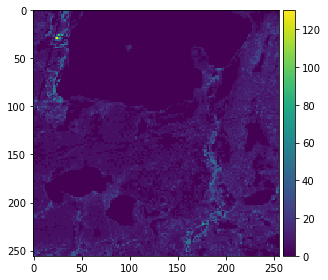

In [56]:
io.imshow(labels[0])

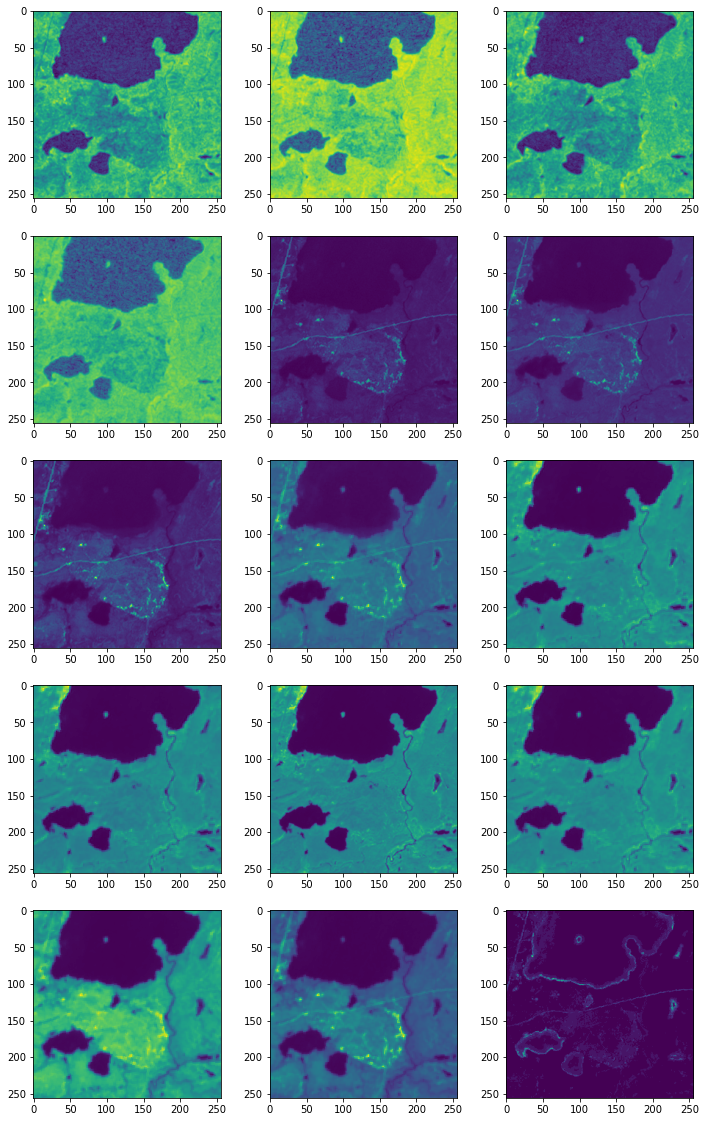

In [57]:
cols = 3
rows = 5
s = 4
fig, axes = plt.subplots(5, 3, figsize=(s*cols, s*rows))
for img, ax in zip(imgs[0], axes.ravel()):
    ax.imshow(img)

In [58]:
imgs = np.array(imgs)
labels = np.array(labels)

In [59]:
imgs.shape

(100, 15, 256, 256)

In [60]:
imgs.min(0).min(-1).min(-1)

array([  -24.627613,   -45.903343, -9999.      , -9999.      ,
           0.      ,     0.      ,     0.      ,     0.      ,
           0.      ,     0.      ,     0.      ,     0.      ,
           0.      ,     0.      ,     0.      ], dtype=float32)

In [61]:
imgs.max(0).max(-1).max(-1).astype(np.uint16)

array([   22,    11,    17,     9, 12904, 12152, 11984, 12491, 12243,
       11918, 12560, 11752,  9358,  9509,   255], dtype=uint16)

In [62]:
imgs.mean(0).mean(-1).mean(-1)

array([ -11.116592,  -17.381275, -810.24536 , -816.0458  ,  271.37137 ,
        431.48428 ,  328.6726  ,  707.1578  , 1719.2126  , 2016.621   ,
       2125.8877  , 2202.0298  , 1173.1371  ,  633.9579  ,   17.336647],
      dtype=float32)

In [63]:
labels.shape

(100, 256, 256)

In [64]:
labels.min(), labels.max(), labels.mean()

(0.0, 5904.32, 62.326748)

In [65]:
np.percentile(labels, 99.99)

633.8099975585938

In [66]:
imgs = np.moveaxis(imgs, 1, -1).reshape(-1, 15)

In [67]:
imgs.shape

(6553600, 15)

In [84]:
df_feat = pd.DataFrame(imgs, columns=[str(i) for i in np.arange(15)])
df_feat['label'] = labels.ravel()

In [85]:
df_feat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,-11.510057,-17.582695,-10.098112,-16.287371,311.0,453.0,466.0,1049.0,2021.0,2282.0,2498.0,2695.0,2510.0,1312.0,0.0,6.73
1,-10.898107,-18.602913,-9.767068,-16.915709,298.0,487.0,451.0,1073.0,2095.0,2491.0,2798.0,2794.0,2455.0,1243.0,0.0,6.73
2,-11.638308,-19.485950,-9.966002,-17.765825,361.0,469.0,520.0,1072.0,1996.0,2310.0,2568.0,2656.0,2548.0,1366.0,0.0,6.53
3,-12.389042,-18.934328,-10.705452,-18.838497,370.0,515.0,525.0,987.0,1980.0,2326.0,2402.0,2580.0,2512.0,1311.0,0.0,6.53
4,-12.196975,-18.523462,-12.090233,-19.472631,338.0,499.0,458.0,987.0,1980.0,2326.0,2500.0,2580.0,2512.0,1311.0,0.0,8.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553595,-10.974414,-15.880520,-12.201468,-16.332876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
6553596,-10.471365,-16.156374,-11.752162,-16.331182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.71
6553597,-10.244892,-16.833307,-11.353154,-15.578461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.71
6553598,-10.465971,-17.248430,-11.331487,-16.688019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.19


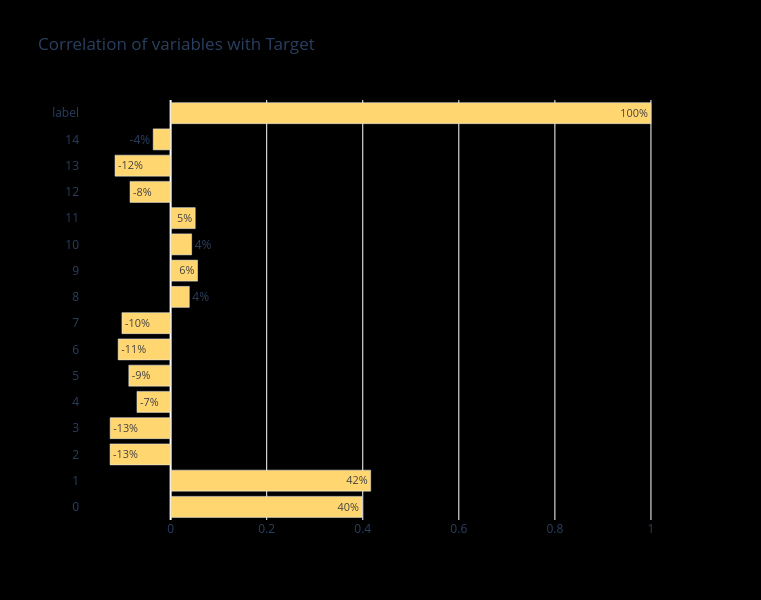

In [86]:
palette = cycle(["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"])
targ = df_feat.corrwith(df_feat['label'], axis=0)
val = [str(round(v * 100)) + '%' for v in targ.values]
fig = go.Figure()
fig.add_trace(go.Bar(y=targ.index, x= targ.values, orientation='h',
                     text = val, marker_color = next(palette)))
fig.update_layout(title = "Correlation of variables with Target", 
                  width = 1200, height = 600,
                  paper_bgcolor='rgb(0,0,0,0)',plot_bgcolor='rgb(0,0,0,0)')